# PowerAI Vision Model Validation

A PowerAI Vision model is built with testing and training within the PowerAI Vision UI. Additional manual testing can be done from within the UI.
This notebook demonstrates a variety of metrics that can be collected using Python code and the API endpoint of a deployed model.  The test images
are read from local directories and the results are shown in this notebook and also exported to CSV files.

![](../doc/source/images/confusion_matrix.png)

## Required Setup

Edit the following cell to provide the API endpoint of your deployed PowerAI Vision model in the URL variable.
Customize additional constants (e.g. set your input directory) as needed.

In [6]:
# Copy/paste API endpoint from your PowerAI Vision deployed model.
URL = 'https://url/guid'

# Provide an input directory. Its subdirectories contain test images.
INPUT_DIR = '../data/test'  # Use subdir names as ground truth category names or category_map

OUTPUT_PREFIX = 'result' # For output CSV file(s)

# WARNING: If False, for convenience, we are not validating the certificate when using the PowerAI API endpoint.
VERIFY_CERT = False

# Map directory name of test data to a category name. If not mapped, the directory name will be used.
category_map = {'directory_name': 'map-to-category-name',
                'Aircraft': 'aircraft',
                'Watercraft': 'watercraft',
                'Land vehicle': 'land vehicle'}

## Python Modules

In [7]:
!pip install --user pandas_ml==0.6.1

You should consider upgrading via the 'pip install --upgrade pip' command.


## Imports

In [8]:
from __future__ import print_function
import collections
import json
import os
import re
import requests
import time
import logging
import csv

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn
import pandas
from pandas_ml import ConfusionMatrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, matthews_corrcoef

## Logging

In [9]:
# Use logger to control debug output levels.
logging.basicConfig()
logger = logging.getLogger("logger")
# Set desired logging to ERROR, INFO, WARNING, or DEBUG.
logger.setLevel("ERROR")
logger.debug("FYI -- Debug logging is enabled.")
logger.info("FYI -- Info logging is enabled.")
logger.error("FYI -- Error logging is enabled.")
requests.packages.urllib3.disable_warnings()

ERROR:logger:FYI -- Error logging is enabled.


## Inference Functions

In [10]:
# Use regular expression to only classify JPG or PNG images.
file_matcher = re.compile("jpg$|jpeg$|png$", re.IGNORECASE)

#------------------------------------
# classify files in directory and save results in dict
# returns dict upon completion
def classifyFiles(directory, normalize):
    results = {}
    totalFiles = 0
    skippedFiles = 0
    processedFiles = 0
    classifiedFiles = 0
    unclassifiedFiles = 0
    problemFiles = 0

    # To help track millisecond time for each inference
    current_milli_time = lambda: int(round(time.time() * 1000))

    logger.info("Classifying directory: {}".format(directory))
    for filename in os.listdir(directory):
        totalFiles += 1
        if file_matcher.search(filename):
            logger.debug("classifying {}".format(filename))

            processedFiles += 1
            filepath = os.path.join(directory, filename)
            files = {'files': open(filepath, 'rb')}

            startMilli = current_milli_time()
            rsp = requests.post(URL, verify=False, auth=None, files=files)
            stopMilli = current_milli_time()
            duration = stopMilli - startMilli
            logger.debug("classified {} in {} millis".format(filename, duration))
            if rspOk(rsp):
                result = rsp.json()
                logger.debug("json={}".format(json.dumps(result)))
                if "classified" in result:
                    classification = result["classified"]
                    logger.debug("classification = {}".format(json.dumps(classification)))
                    for classname in classification.keys():
                        confidence = classification[classname]

                        if classname == "negative":
                            unclassifiedFiles += 1
                            if normalize:
                                # translate 'negative' to 'non-classified' for better clarity
                                classname = "unclassified"
                                confidence = 0
                        else:
                            classifiedFiles += 1

                        logger.debug("Saving result {}, {}, {}".format(filename, classname, confidence))
                        results[filename] = {"filename": filename,
                                             "classification": classname,
                                             "confidence": confidence,
                                             "duration": duration}
                else:
                    problemFiles += 1
                    results[filename] = {"filename": filename,
                                         "classification": "None",
                                         "confidence": "",
                                         "duration": duration}
                    logger.warning("No classification for {}".format(filename))
            else:
                logger.error("ERROR")
                problemFiles += 1
                logger.error("Error result from server for {}".format(filename))
        else:
            skippedFiles += 1
            logger.info("skipping non-image file {}".format(filename))

    logger.info("TotalFiles: {}, ProcessedFiles: {}, classifiedFiles: {}, unclassifiedFiles: {}, skippedFiles: {}, problemFiles: {}".
                 format(totalFiles, processedFiles, classifiedFiles, unclassifiedFiles, skippedFiles, problemFiles))
    return results

# ------------------------------------
# Checks if result from Vision API succeeded
# (Current API returns failure indication in the JSON body)
def rspOk(rsp):
    logger.debug("status_code: {}, OK={}.".format(rsp.status_code, rsp.ok))

    if rsp.ok:
        try:
            jsonBody = rsp.json()
            if ("result" in jsonBody) and (jsonBody["result"] == "fail"):
                result = False
                logger.debug(json.dumps(jsonBody, indent=2))
            else:
                result = True
        except ValueError:
            result = True
            logger.error("good status_code, but no data")
    else:
        result = False

    return result

# Use dirname to get ground truth category name from map (default to dirname)
def get_ground_truth(dirname):
    return category_map.get(dirname, dirname)


## Main

The main logic starts here and continues below.

* Loop over the `INPUT_DIR` sub-directories.
* Call the inference function on each image file.
* Use the built truth and predicted lists for the rest (below).

  * "truth" lists the classification we want for the image.
  * "predicted" lists the classification we got from the inference call.

In [11]:
#
# MAIN
#

truth = []
predicted = []

for dirname in os.listdir(INPUT_DIR):
    if not os.path.isdir(os.path.join(INPUT_DIR, dirname)):
        continue
    
    result_dict = classifyFiles(os.path.join(INPUT_DIR, dirname), False)
    logger.debug(result_dict)
    
    for k,v in result_dict.items():
        truth.append(get_ground_truth(dirname))  # Ground truth determined from dirname
        predicted.append(v['classification'])  # The predicted classification
        
confusion_matrix = ConfusionMatrix(truth, predicted)

/Users/markstur/.local/lib/python3.6/site-packages/pandas_ml/confusion_matrix/abstract.py:66: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  df = df.loc[idx, idx.copy()].fillna(0)  # if some columns or rows are missing


## Plot the confusion matrix

Using matplotlib and seaborn, we can graphically show the confusion matrix.

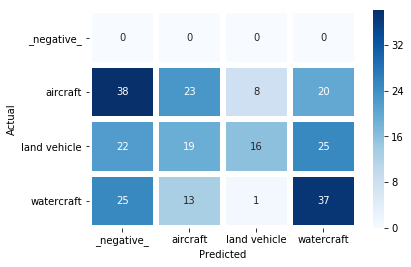

In [12]:
confusion_matrix.plot(backend='seaborn', annot=True, linewidth=5, cmap='Blues');

## Plot the normalized confusion matrix

Setting `normalized=True` gives us values from 0 to 1. This may be a better representation when the wights are uneven.

/Users/markstur/.local/lib/python3.6/site-packages/pandas_ml/confusion_matrix/abstract.py:115: RuntimeWarning: invalid value encountered in true_divide
  a = a.astype('float') / a.sum(axis=1)[:, np.newaxis]


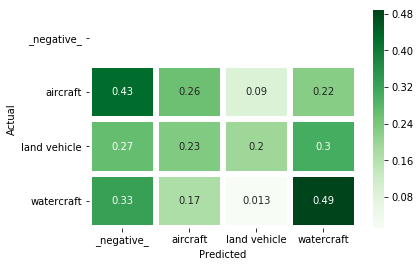

In [13]:
confusion_matrix.plot(normalized=True, backend='seaborn', annot=True, linewidth=5, cmap='Greens');

## Classification metrics

In [14]:
# The handiest way to see the stats is with print_stats().
# But since we're coding for CSV output we have prettier ways
# to show the data below.

# confusion_matrix.print_stats()

### Collect the classification metrics by class and write them to a CSV

In [15]:
stats = confusion_matrix.stats()

class_csv = OUTPUT_PREFIX + "_class.csv"
logger.info("Writing stats by class to: " + class_csv)

with open(class_csv, "w") as outfile:
    csvwriter = csv.writer(outfile)

    first = True
    for classification, v in stats['class'].items():
        header = ['class']
        row = [classification]
        for x, y in v.items():
            header.append(x)
            row.append(y)
        if first:
            csvwriter.writerow(header)
            first = False
        csvwriter.writerow(row)

# Read and show the CSV file.
df = pandas.read_csv(class_csv)
df.style.hide_index()  # Preview here. To see the whole thing open the CSV file.

/Users/markstur/.local/lib/python3.6/site-packages/pandas_ml/confusion_matrix/stats.py:60: FutureWarning: supplying multiple axes to axis is deprecated and will be removed in a future version.
  num = df[df > 1].dropna(axis=[0, 1], thresh=1).applymap(lambda n: choose(n, 2)).sum().sum() - np.float64(nis2 * njs2) / n2
/Users/markstur/.local/lib/python3.6/site-packages/pandas_ml/confusion_matrix/bcm.py:191: RuntimeWarning: invalid value encountered in double_scalars
  return(np.float64(self.TP) / self.P)
/Users/markstur/.local/lib/python3.6/site-packages/pandas_ml/confusion_matrix/bcm.py:276: RuntimeWarning: invalid value encountered in double_scalars
  return(np.float64(self.FN) / self.P)
/Users/markstur/.local/lib/python3.6/site-packages/pandas_ml/confusion_matrix/bcm.py:302: RuntimeWarning: invalid value encountered in true_divide
  * (self.TN + self.FP) * (self.TN + self.FN)))


class,Population,P: Condition positive,N: Condition negative,Test outcome positive,Test outcome negative,TP: True Positive,TN: True Negative,FP: False Positive,FN: False Negative,"TPR: (Sensitivity, hit rate, recall)",TNR=SPC: (Specificity),PPV: Pos Pred Value (Precision),NPV: Neg Pred Value,FPR: False-out,FDR: False Discovery Rate,FNR: Miss Rate,ACC: Accuracy,F1 score,MCC: Matthews correlation coefficient,Informedness,Markedness,Prevalence,LR+: Positive likelihood ratio,LR-: Negative likelihood ratio,DOR: Diagnostic odds ratio,FOR: False omission rate
_negative_,247,0,247,85,162,0,162,85,0,nan,0.65587,0,1,0.34413,1,nan,0.65587,0,nan,nan,0,0,nan,nan,nan,0
aircraft,247,89,158,55,192,23,126,32,66,0.258427,0.797468,0.418182,0.65625,0.202532,0.581818,0.741573,0.603239,0.319444,0.0645011,0.0558953,0.0744318,0.360324,1.27598,0.929909,1.37216,0.34375
land vehicle,247,82,165,25,222,16,156,9,66,0.195122,0.945455,0.64,0.702703,0.0545455,0.36,0.804878,0.696356,0.299065,0.21949,0.140576,0.342703,0.331984,3.57724,0.851313,4.20202,0.297297
watercraft,247,76,171,82,165,37,126,45,39,0.486842,0.736842,0.45122,0.763636,0.263158,0.54878,0.513158,0.659919,0.468354,0.219226,0.223684,0.214856,0.307692,1.85,0.696429,2.65641,0.236364


In [16]:
df.T  # Same data as above, but transposed for a better view of the metrics (perhaps).

,0,1,2,3
class,_negative_,aircraft,land vehicle,watercraft
Population,247,247,247,247
P: Condition positive,0,89,82,76
N: Condition negative,247,158,165,171
Test outcome positive,85,55,25,82
Test outcome negative,162,192,222,165
TP: True Positive,0,23,16,37
TN: True Negative,162,126,156,126
FP: False Positive,85,32,9,45
FN: False Negative,0,66,66,39


## Calculate the overall metrics

The TP, TN, FP, and FN can be summed using the confusion matrix data frame.

In [17]:
# Get total TP, TN, FP, FN.
tp_tn_fp_fn = df.agg({'TP: True Positive': ['sum'],
                      'TN: True Negative': ['sum'],
                      'FP: False Positive': ['sum'],
                      'FN: False Negative': ['sum']})
tp_tn_fp_fn

,TP: True Positive,TN: True Negative,FP: False Positive,FN: False Negative
sum,76,570,171,171


## Use count to calculate the number of classes

In [18]:
# Get total class count.
class_count = df.agg({'class': ['count']})
class_count

,class
count,4


## Use max to calculate the number of images classified

In [19]:
# Get total population.
population = df.agg({'Population': ['max']})
population

,Population
max,247


## pandas-ml provides some overall metrics in a classification report

This is the easy way, but it only offers weighted metrics and does not include MCC.

In [20]:
# Weighted classification report
classification_report = confusion_matrix.classification_report
classification_report

/Users/markstur/.local/lib/python3.6/site-packages/pandas_ml/confusion_matrix/bcm.py:191: RuntimeWarning: invalid value encountered in double_scalars
  return(np.float64(self.TP) / self.P)


,precision,recall,F1_score,support
Classes,,,,
_negative_,0,NaN,0,0
aircraft,0.418182,0.258427,0.319444,89
land vehicle,0.64,0.195122,0.299065,82
watercraft,0.45122,0.486842,0.468354,76
__avg / total__,0.501987,0.307692,0.358497,247


## Use sklearn.metrics directly to get more metrics

This gives us MCC and accuracy and also allows us to specify "macro" or "weighted" where applicable.

In [21]:
accuracy = accuracy_score(truth, predicted)

average = 'weighted'  # Use 'macro' or 'weighted'
precision = precision_score(truth, predicted, average=average)
recall = recall_score(truth, predicted, average=average)
f1 = f1_score(truth, predicted, average=average)
mcc = matthews_corrcoef(truth, predicted)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


## Combine the overall metrics and write them to a CSV file

In [22]:
summary_csv = OUTPUT_PREFIX + "_summary.csv"
logger.info("Writing stats summary to: " + summary_csv)

# Pull some numbers out of the dataframes shown earlier
images = population.iat[-1, -1]
classes = class_count.iat[-1, -1]
tp = tp_tn_fp_fn['TP: True Positive']['sum']
tn = tp_tn_fp_fn['TN: True Negative']['sum']
fp = tp_tn_fp_fn['FP: False Positive']['sum']
fn = tp_tn_fp_fn['FN: False Negative']['sum']

# Combine the metrics in a CSV with a header
with open(summary_csv, "w") as outfile:
    csvwriter = csv.writer(outfile)

    first = True
    header = ['# of Classes', '# of Images', 'TP', 'TN', 'FP', 'FN', 'Precision', 'Recall', 'Accuracy', 'F1', 'MCC']
    row = [classes, images, tp, tn, fp, fn, precision, recall, accuracy, f1, mcc]
    csvwriter.writerow(header)
    csvwriter.writerow(row)
    
# Read and show the CSV file.
summary = pandas.read_csv(summary_csv) # Preview the CSV file here
summary.style.hide_index()

# of Classes,# of Images,TP,TN,FP,FN,Precision,Recall,Accuracy,F1,MCC
4,247,76,570,171,171,0.501987,0.307692,0.307692,0.358497,0.133293


<font size=-1 color=gray>
<hr>
&copy; Copyright 2003,2016,2019 IBM Corp. All Rights Reserved.
<p>
Licensed under the Apache License, Version 2.0 (the "License"); you may not use this file
except in compliance with the License. You may obtain a copy of the License at
https://www.apache.org/licenses/LICENSE-2.0
Unless required by applicable law or agreed to in writing, software distributed under the
License is distributed on an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either
express or implied. See the License for the specific language governing permissions and
limitations under the License.
</font></p>
